In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# linux command to change directory
%cd /content/gdrive/MyDrive/Coding/Afnan/Models

/content/gdrive/MyDrive/Coding/Afnan/Models


In [ ]:
# linux command to list files in current directory
!ls

Bert.ipynb     CNN.ipynb  LSTM.ipynb		   model.png
Bi-LSTM.ipynb  Embedding  LSTM_With_BI-LSTM.ipynb  preprocessed.csv


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, KeyedVectors
import os

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding , Dense , LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# metrics
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay


In [ ]:
# loading processed text
data = pd.read_csv('preprocessed.csv')
data = data[['Text','Compartive']]
data.head()

,Text,Compartive
0,يقولك تطبيقات ابل افضل سامسونغ اعرف دفيع واهبل...,1
1,معليش لازم نكون نفسك نصير سبايك داءما حقين ا...,1
2,تر ابل افضل شركات الجولات الاستخدام عشان الن...,1
3,وجهه نظري ابل افضل ناحيه الاستخدام العام الان...,1
4,جهاز متصل بالنت فاهو جهاز امن بس الحق ينقال...,1


In [ ]:
# split data into trainin and tesing
x_train, x_test, y_train, y_test = train_test_split(data['Text'],data['Compartive']
                                                    ,test_size=0.15,random_state=44)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((479,), (479,), (85,), (85,))

### Tokenizer Tutorial :: https://www.youtube.com/watch?v=TIw-MMJRSeE

In [ ]:
# define tokenizer 
# let's say we have a sentence "she is going to school" , tokenizer convert it in inteligent
# way into she is go ##ing to school , ## mean than the words is belong to the previous
tokenizer = Tokenizer()
# fit the tokenzier into out the dataset
tokenizer.fit_on_texts(data['Text'])
# word_index contains the word and its index
wordIndex = tokenizer.word_index
# check the word index by getting the index of some Words
print(list(wordIndex.items())[:10])

[('ابل', 1), ('افضل', 2), ('سامسونج', 3), ('نظام', 4), ('اندرويد', 5), ('شركه', 6), ('بس', 7), ('الاندرويد', 8), ('ناحيه', 9), ('اجهزه', 10)]


In [ ]:
# check how many words do we have
len(tokenizer.word_index)

3420

In [ ]:
max_len = 35
# Because Tokenizer.word_index is a python dictionary that contains token keys (string) and
# token ID values (integer), and where the first token ID is 1 (not zero) and 
# where the token IDs are assigned incrementally. Therefore, the greatest token ID
# in word_index is len(word_index). Therefore, we need vocabulary of size len(word_index) + 1 to
# be able to index up to the greatest token ID.
vocab_len = len(wordIndex) + 1
print(f'Max length of words in  {max_len}')
print(f'Number of Words {vocab_len}')

Max length of words in  35
Number of Words 3421


## Word2Vec Tutorial :: https://www.youtube.com/watch?v=xqRneE2f2kg

In [ ]:
# embedding dictionary to save all words and its embedding vector in it
w2vEmbedding_index = {}
# the size of embedding vector
emb_dimension = 300
# the path of embedding file
embeddings_file="Embedding/tweets_cbow_300"
# load word2vec model with its pretrained embedding
w2v_model =KeyedVectors.load(embeddings_file)
# loop over the words in word2vec vocab
for word in w2v_model.wv.vocab:
  # assign the word as a key and its vector as a value in dictionary
  w2vEmbedding_index[word] = w2v_model.wv[word]

In [ ]:
# define embedding matrix that model will use and it has all words in our dataset
# its dimension number of words , size of vector
embedding_matrix = np.zeros((vocab_len,emb_dimension))
# loop voer the words in word_index 
for word,i in tokenizer.word_index.items():
  # get embedding vector from embedding dictionary that has all words representations
  embedding_vector = w2vEmbedding_index.get(word)
  # check that embedding vector is not equal to None
  if embedding_vector is not None:
    # assign embedding vector to martix
    embedding_matrix[i] = embedding_vector

print("Embedding Matrix shape:", embedding_matrix.shape)

Embedding Matrix shape: (3421, 300)


In [ ]:
# convert each word in the text into a integer 
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# pad_sequences is used to ensure that all sequences in a list have the same length
# By default this is done by padding 0 in the beginning 
# of each sequence until each sequence has the same length as the longest sequence.
# padding = 'post' to make padding done 0 in the ending of the sequence

x_train = pad_sequences(x_train,maxlen=max_len, padding='post')
x_test = pad_sequences(x_test,maxlen=max_len, padding='post')

RELU function :- With default values, this returns max(x, 0), the element-wise maximum of 0 and the input tensor. Modifying default parameters allows you to use non-zero thresholds, change the max value of the activation, and to use a non-zero multiple of the input for values below the threshold.


In [ ]:
# define model, Sequential mean that each layer output is delivered to the next layer
model = Sequential([
        # Embedding is used to gets the Representation of Every Input sequences,
        # by defult it is initilized Randomly , but here we will load our weights from Embedding Matrix
        # and set it Non Trainable  
        Embedding(vocab_len,emb_dimension,weights=[embedding_matrix],
                  input_length=max_len,trainable=False),
        # define LStm layer with 512 neuron in it
        # return sequences means that lstm will return All Hidden States
        LSTM(512,return_sequences=True),
        # dropout layer to reduce overfitting 
        Dropout(0.5),
        # define LStm layer with 256 neuron in it
        LSTM(256),
        Dropout(0.5),
        Dense(1,activation='sigmoid')
    ])

In [ ]:
# model.summary() to print a useful summary of the model, which includes:
  #Name and type of all layers in the model.
  #Output shape for each layer.
  #Number of weight parameters of each layer.
  #If the model has general topology (discussed below), the inputs each layer receives
  #The total number of trainable and non-trainable parameters of the model.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           1026300   
                                                                 
 lstm (LSTM)                 (None, 35, 512)           1665024   
                                                                 
 dropout (Dropout)           (None, 35, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 3,479,037
Trainable params: 2,452,737
Non-

## CallBacks

In [ ]:
# define model configrations for training such as optimizer,loss,metrics and callbacks
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])
# loss indicates to penalty for a bad prediction,
# its number indicating how bad the model's prediction is on a single example.
#if the model is prefect then the loss = 0

In [ ]:
# Stop training when a monitored metric has stopped improving.
  # monitor > Quantity to be monitored
  # patience > Number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_accuracy',patience=2,mode='max')

# os.getcwd is used to get path of current direcotry then pass it to join function that used to joining
# two file pathes 
file_path = os.path.join(os.getcwd(),"checkPoints/LSTM/model.h5")
check_point = ModelCheckpoint(filepath=file_path,
                              # monitor is the metrics that we want to optimize
                              monitor='val_accuracy',
                              # mode tells that we look for maximize this monitor
                              mode='max',
                              # ensure that the lasest best model (accroding to the metrics) will not
                              # change
                              save_best_only=True,
                              save_wrights_only=True,
                              #set logs notification during model training
                              verbose=1)

### `Validation Data` is used to get feedback on how our model perfrom in every epoch

In [ ]:
# push data to model and start training
history = model.fit(x_train,y_train,
                    
                    validation_data=(x_test,y_test) , epochs= 5,
                    callbacks=[early_stop, check_point])
# Epochs : number of times the learning algorthim will work through the entire training data

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8622
Epoch 1: val_accuracy improved from -inf to 0.57647, saving model to /content/gdrive/MyDrive/Coding/Afnan/Models/checkPoints/model.h5
15/15 [==============================] - 11s 726ms/step - loss: 0.3983 - accuracy: 0.8622 - val_loss: 0.7022 - val_accuracy: 0.5765
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8497
Epoch 2: val_accuracy improved from 0.57647 to 0.88235, saving model to /content/gdrive/MyDrive/Coding/Afnan/Models/checkPoints/model.h5
15/15 [==============================] - 11s 767ms/step - loss: 0.4174 - accuracy: 0.8497 - val_loss: 0.3800 - val_accuracy: 0.8824
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8706
Epoch 3: val_accuracy did not improve from 0.88235
15/15 [==============================] - 11s 723ms/step - loss: 0.3875 - accuracy: 0.8706 - val_loss: 0.3800 - val_accuracy: 0.8824
Epo

In [ ]:
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='Validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show
  

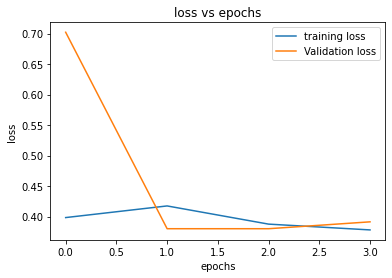

In [ ]:
plot_graph(history,'loss')

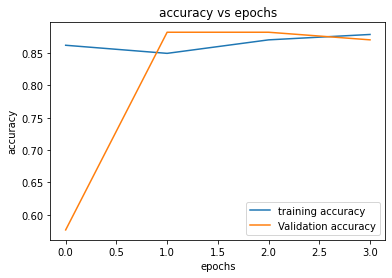

In [ ]:
plot_graph(history,'accuracy')

In [ ]:
print("Model Performance on test set")
# evaluate is used to check the final model with test data , to show how to model will evalute in production
result = model.evaluate(x_test,y_test)
print(dict(zip(model.metrics_names, result)))

Model Performance on test set
3/3 [==============================] - 0s 117ms/step - loss: 0.3913 - accuracy: 0.8706
{'loss': 0.39127835631370544, 'accuracy': 0.8705882430076599}


In [7]:
# if the value greater that .5 then equal to 1  else than equal to 0
np.round(.6)

1.0

In [ ]:
y_predict = np.round(model.predict(x_test))
y_predict[:10]

3/3 [==============================] - 1s 132ms/step


array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

### Accuracy Score

In [ ]:
acc_score = accuracy_score(y_test, y_predict)
print(f"Accuracy of our model is {acc_score}")

Accuracy of our model is 0.8705882352941177


#### Confusion Matrix
### is the visual representation of the Actual VS Predicted values. It measures the performance of our Machine Learning classification model and looks like a table-like structure.

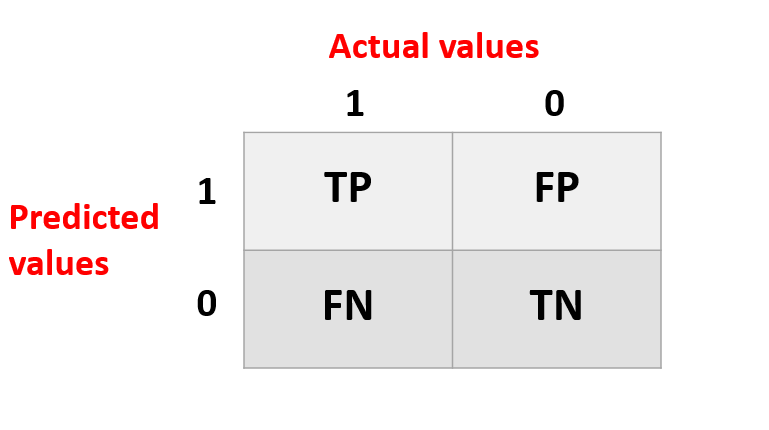

Elements of Confusion Matrix
It represents the different combinations of Actual VS Predicted values. Let’s define them one by one.

* TP: True Positive: The values which were actually positive and were predicted positive.

* FP: False Positive: The values which were actually negative but falsely predicted as positive. Also known as Type I Error.

* FN: False Negative: The values which were actually positive but falsely predicted as negative. Also known as Type II Error.

* TN: True Negative: The values which were actually negative and were predicted negative.



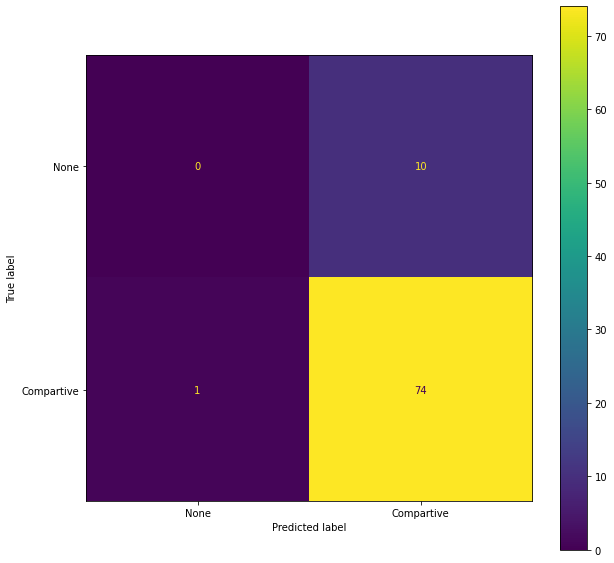

In [ ]:
# specify axis with  figure size 
fig,ax = plt.subplots(figsize=(10,10))
# getting confusion matrix
confusion = confusion_matrix(y_test, y_predict)
# confusionMatraxDisplay is used to create a confusion matrix plot from confusion
display_con = ConfusionMatrixDisplay(confusion,display_labels=['None',"Compartive"])
# the confusion matrix with respect to axis defined above
display_con.plot(ax=ax)
plt.show()

In [ ]:
class_report = classification_report(y_test,y_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.88      0.99      0.93        75

    accuracy                           0.87        85
   macro avg       0.44      0.49      0.47        85
weighted avg       0.78      0.87      0.82        85

